In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'size'   : 12}
rc('font', **font)
path = '../original_data/sdss_secondary.csv'

In [26]:
dtype1 = {'uid': np.uint32,  'objID'  : np.uint64, 
          'ra' : np.float64, 'ra_ref' : np.float64,
          'dec': np.float64, 'dec_ref': np.float64,
          'get_nearby_distance': np.float128,
          'mjd_r': np.float64}
dtype2 = {band + 'psf'   : np.float64 for band in 'ugriz'}
dtype3 = {band + 'psferr': np.float64 for band in 'ugriz'}
df = pd.read_csv(path, dtype = {**dtype1, **dtype2, **dtype3})
df['get_nearby_distance'] *= 60.0

93216     61
64542     59
71031     57
56027     56
101058    56
Name: uid, dtype: int64


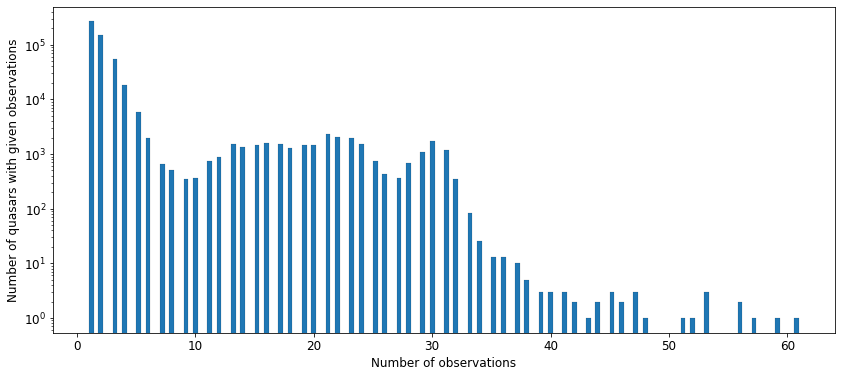

In [27]:
fig, ax = plt.subplots(1,1,figsize = (14,6));
ax.hist(df['uid'].value_counts(), bins = 150, lw = 0.1, edgecolor = 'k');
ax.set(yscale = 'log', xlabel = 'Number of observations', ylabel = 'Number of quasars with given observations');
print(df['uid'].value_counts().head())

In [17]:
# Plotting lcs
# single_object = df[df['uid'] == df['uid'].value_counts().index[10]]
# single_object = single_object[single_object['upsf'] != -9999]
# mjd, u, g, r, i, z = single_object[['mjd_r']  + [band + 'psf' for band in 'ugriz']].values.T
# single_object
# fig, ax = plt.subplots(1,1, figsize = (15,5))
# for mag, color in zip([u,g,r,i,z],'mgrkb'):
#     ax.scatter(mjd, mag, color = color)
# ax.set(xlabel = 'mjd', ylabel = 'mag')#,xlim = [53270,53320])
# ax.invert_yaxis()

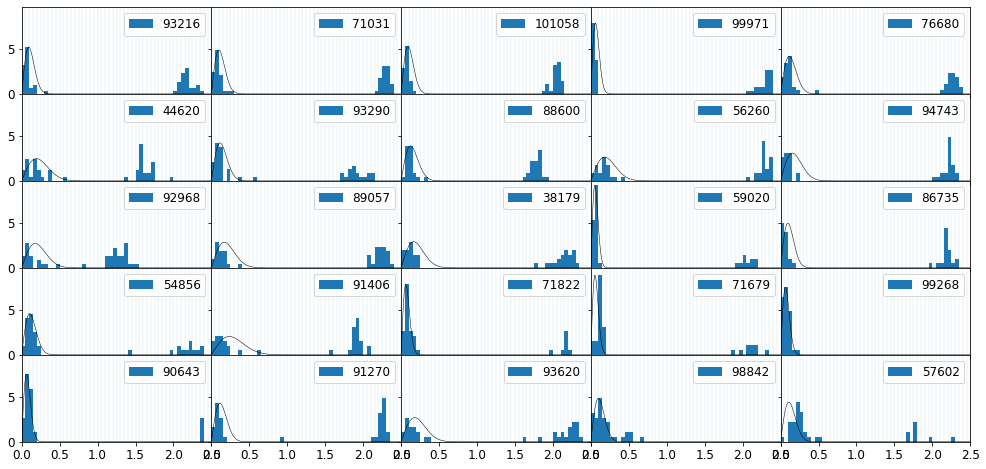

In [23]:
# from unidip import UniDip
# from matplotlib.collections import Collection

#filter out bad obs, though there appear to be none already
df = df[df['upsf'] != -999]

def rayleigh(x,sigma):
    prob = (2.0 / np.pi)**0.5 * sigma**-2 * x * np.exp(-0.5*(x/sigma)**2)
    return prob
x0 = np.linspace(0,2.5,250)

n = 5
skip = 2
fig, axes = plt.subplots(n,n, figsize = (17,8), sharex = True, sharey = True);
uids = df['uid'].value_counts().head(skip*n**2).index[::skip]
for ax,uid in zip(axes.ravel(),uids):
    displacements = df[df['uid'] == uid]['get_nearby_distance'].sort_values().values
    
    #Grid bin edges on plot
    counts, bins, _ = ax.hist(displacements, bins = 50, range = (0,2.5), label = str(uid),density = True);
    for binedge in bins:
        ax.axvline(x = binedge, lw = 0.1)
        
    #plot rayleigh distribution
    sigma = (2/np.pi)**0.5*np.exp(-0.5)/np.max(counts[:len(counts)//2])
    ax.plot(x0,rayleigh(x0,sigma), lw = 0.5, color = 'k')
        
#     #Plot Hartigan Dip-Test intervals
#     intervals = UniDip(displacements).run()
#     for interval, color in zip(intervals,'gr'):
#         lower = displacements[interval[0]]
#         upper = displacements[interval[1]]
#         ax.axvline(x = lower, lw = 1, color = 'r')
#         ax.axvline(x = upper, lw = 1, color = 'r')
#         ax.fill_betweenx([0,30],lower,upper, facecolor = color, alpha = 0.5)
    
    ax.set(xlim = [0,2.5]);
    ax.legend(loc = 1)
    
plt.subplots_adjust(wspace = 0, hspace = 0)

Create a table of meta data: uid, ra, dec, meanpsf_ugriz, nobs, Fvar
We test for bimodality of distribiution, assign likelihood that a given point is in each distribution. Then discard all those that do not have a 90% prob of being in primary distribution. We could do this buy creating gaussian (or x^2exp(-x^2) as this captures prob of radial displacement from origin..) then throw out points which have a small prob of being in the distribution!

Also multi objects tend to be dominant in higher obs counts.

Dip test doesnt distinguish well enough (why not?)
Instead lets simply use x^2exp(-x^2) (double check this is the right distribution)
We could get even more sophisticated and use ra/dec variance to deviate from rayleigh distribution. Also possible to introduce a mean for systematic error.